In [1]:
import my_plotting
import markers
import importlib
import utils
import covax_constants
import CovidVAX_specific_utils
import GeneModules

importlib.reload(my_plotting);
importlib.reload(markers);
importlib.reload(utils);
importlib.reload(covax_constants);
importlib.reload(GeneModules);


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np

import warnings
warnings.simplefilter("ignore")

from functools import partial
import scanpy as sc

import muon as mu
import anndata

In [2]:
pbmc = sc.read_h5ad('gse171964_raw_anndata.h5ad')

In [3]:
pbmc.var_names_make_unique()

In [4]:
sc.pp.filter_cells(pbmc, min_genes=200)
sc.pp.filter_genes(pbmc, min_cells=3)

In [5]:
pbmc.obs['pt_id'] = pd.Categorical(pbmc.obs['pt_id'].astype(str))
pbmc.obs['person'] = pbmc.obs['pt_id'].copy()

In [6]:
pbmc.obs['Visit'] = pd.Categorical(pbmc.obs['day'].map({
    0 : 'Baseline 1',
    1 : 'Vac1 D1',
    2 : 'Vac1 D2',
    7 : 'Vac1 D7',
    21 : 'Baseline 2',
    22 : 'Vac2 D1',
    28 : 'Vac2 D7',
    42 : 'Vac2 21',
}), categories=['Baseline 1', 'Vac1 D1', 'Vac1 D2', 'Vac1 D7', 'Baseline 2', 'Vac2 D1', 'Vac2 D7', 'Vac2 21'])

In [7]:
pbmc.obs['day'] = pd.Categorical(pbmc.obs['day'].astype(str), categories=['0', '1', '2', '7', '21', '22', '28', '42'])

In [8]:
pbmc.var['is_rna'] = ~pbmc.var_names.str.endswith('_ADT').copy()
pbmc.var['is_protein'] = pbmc.var_names.str.endswith('_ADT').copy()

# Myeloid

In [9]:
myeloid = pbmc[pbmc.obs['clustnm'].isin({
    'C3_CD14+ monocytes', 
    'C4_CD16+ monocytes',
    'C7_cDC2', 
    'C8_CD14+BDCA1+PD-L1+ cells',
    'C13_cDC1',
})].copy()

In [10]:
rna = myeloid[:, myeloid.var['is_rna']].copy()

In [11]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [12]:
def is_outlier(S, nmads: int):
    from scipy.stats import median_abs_deviation
    outlier = (S < np.median(S) - nmads * median_abs_deviation(S)) | (
        np.median(S) + nmads * median_abs_deviation(S) < S
    )
    return outlier

In [13]:
def find_standards(S, nmads: int):
    from scipy.stats import median_abs_deviation

    diff = nmads * median_abs_deviation(S)
    med = np.median(S)
    low =  med - diff[0]
    high = med + diff[0]

    return pd.Series({'Low' : low, 'Median' : med, 'High' : high})


In [14]:
n_genes_sample_standards = rna.obs[['n_genes', 'sample_id']].groupby('sample_id').apply(find_standards, nmads = 3)
n_genes_sample_is_outlier = rna.obs[['n_genes', 'sample_id']].groupby('sample_id').apply(is_outlier, nmads = 3)

In [15]:
per_mito_standards = rna.obs[['pct_counts_mt', 'sample_id']].groupby('sample_id').apply(find_standards, nmads = 3)
per_mito_is_outlier = rna.obs[['pct_counts_mt', 'sample_id']].groupby('sample_id').apply(is_outlier, nmads = 3)

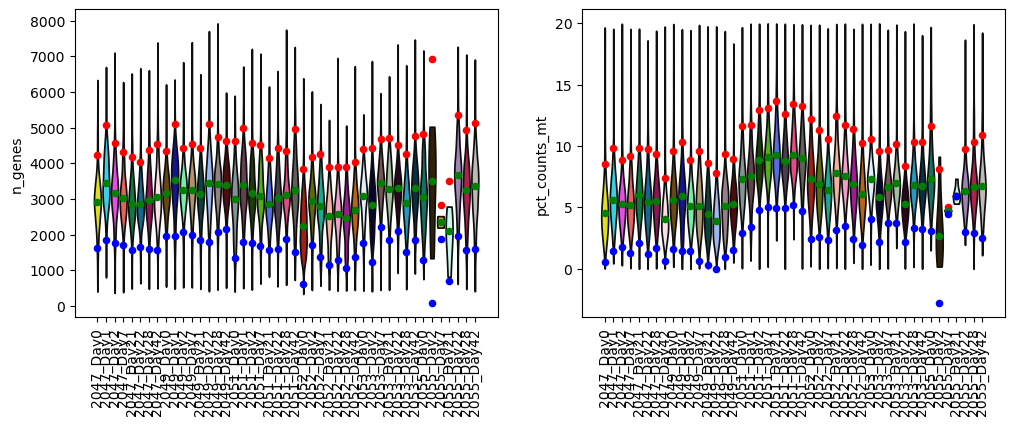

In [16]:
fig, axs= plt.subplots(ncols=2, figsize = (12, 4))
axs = axs.flat
sc.pl.violin(
    rna,
    "n_genes",
    jitter=False,
    multi_panel=True,
    groupby='sample_id',
    rotation=90,
    ax = axs[0],
    show = False,
    size = 0
)

axs[0].scatter(n_genes_sample_standards.index, n_genes_sample_standards['High'], s = 20, c = 'red')
axs[0].scatter(n_genes_sample_standards.index, n_genes_sample_standards['Median'], s = 20, c = 'green')
axs[0].scatter(n_genes_sample_standards.index, n_genes_sample_standards['Low'], s = 20, c = 'blue')


sc.pl.violin(
    rna,
    "pct_counts_mt",
    jitter=False,
    multi_panel=True,
    groupby='sample_id',
    rotation=90,
    ax = axs[1],
    show = False,
    size = 0
)

axs[1].scatter(n_genes_sample_standards.index, per_mito_standards['High'], s = 20, c = 'red')
axs[1].scatter(n_genes_sample_standards.index, per_mito_standards['Median'], s = 20, c = 'green')
axs[1].scatter(n_genes_sample_standards.index, per_mito_standards['Low'], s = 20, c = 'blue');

In [17]:
rna.obs['is_outlier'] = n_genes_sample_is_outlier.droplevel(0).iloc[:, 0] | per_mito_is_outlier.droplevel(0).iloc[:, 0]

In [18]:
rna = rna[~rna.obs.is_outlier].copy()

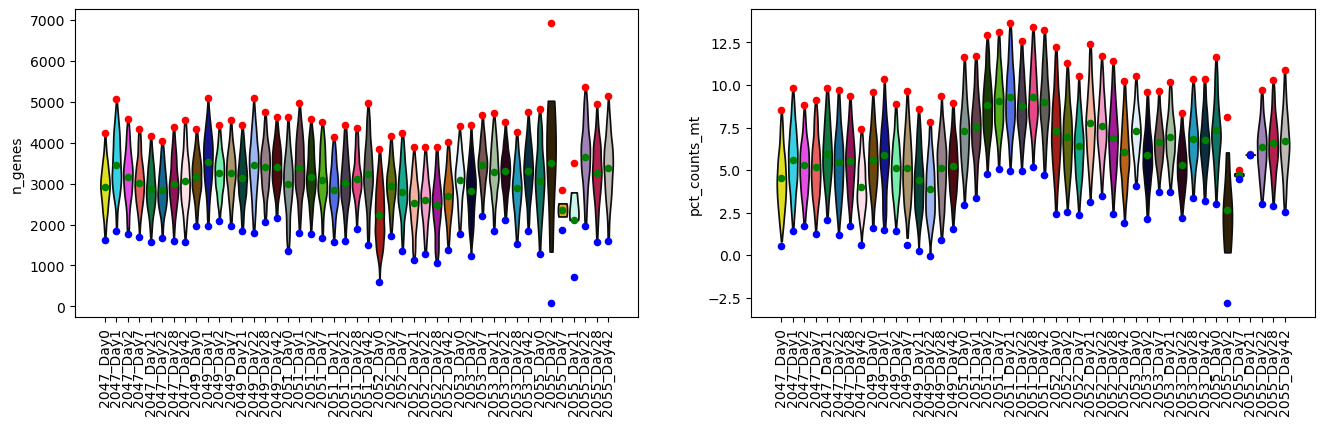

In [19]:
fig, axs= plt.subplots(ncols=2, figsize = (16, 4))
axs = axs.flat
sc.pl.violin(
    rna,
    "n_genes",
    jitter=False,
    multi_panel=True,
    groupby='sample_id',
    rotation=90,
    ax = axs[0],
    show = False,
    size = 0
)

axs[0].scatter(n_genes_sample_standards.index, n_genes_sample_standards['High'], s = 20, c = 'red')
axs[0].scatter(n_genes_sample_standards.index, n_genes_sample_standards['Median'], s = 20, c = 'green')
axs[0].scatter(n_genes_sample_standards.index, n_genes_sample_standards['Low'], s = 20, c = 'blue')


sc.pl.violin(
    rna,
    "pct_counts_mt",
    jitter=False,
    multi_panel=True,
    groupby='sample_id',
    rotation=90,
    ax = axs[1],
    show = False,
    size = 0
)

axs[1].scatter(n_genes_sample_standards.index, per_mito_standards['High'], s = 20, c = 'red')
axs[1].scatter(n_genes_sample_standards.index, per_mito_standards['Median'], s = 20, c = 'green')
axs[1].scatter(n_genes_sample_standards.index, per_mito_standards['Low'], s = 20, c = 'blue');

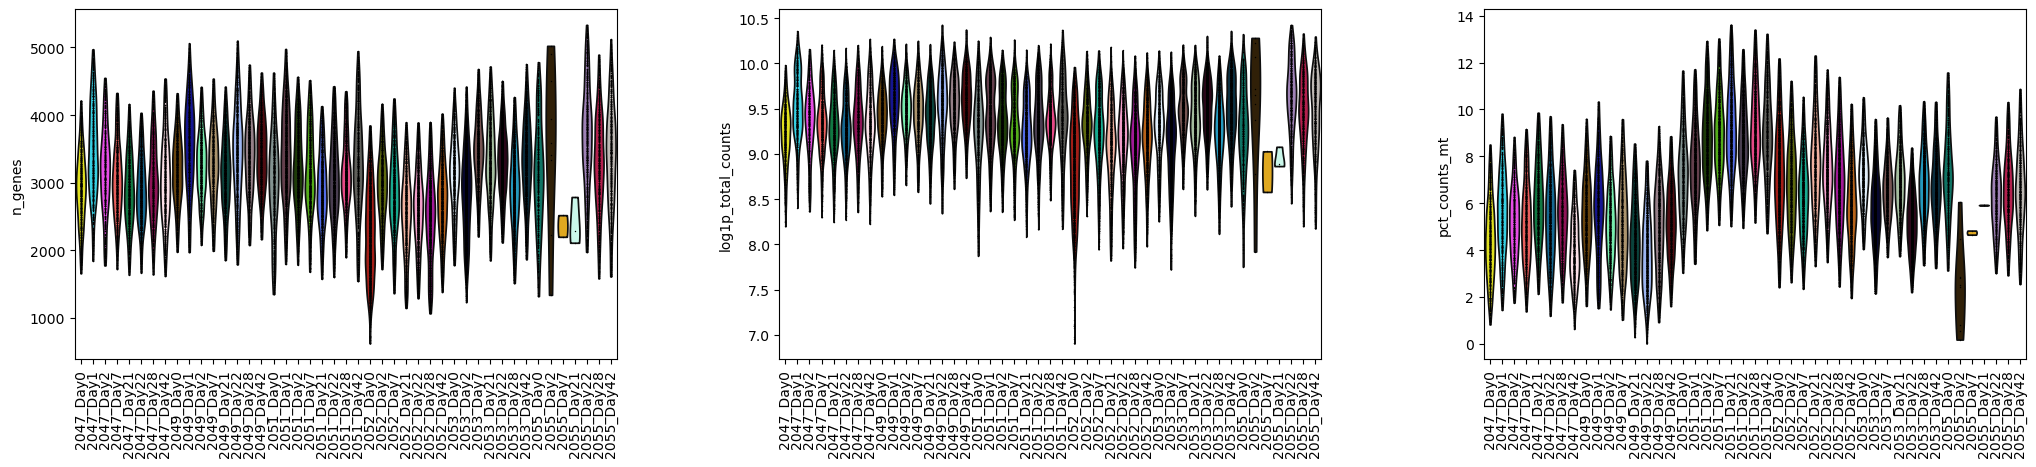

In [20]:
sc.pl.violin(
    rna,
    ["n_genes", "log1p_total_counts", "pct_counts_mt"],
    jitter=False,
    multi_panel=True,
    groupby='sample_id',
    rotation=90
)

In [21]:
rna.layers['counts'] = rna.X.copy()

In [22]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

sc.pp.highly_variable_genes(rna)

In [23]:
adt = myeloid[rna.obs_names, myeloid.var.is_protein].copy()

adt.layers['counts'] = adt.X.copy()

mu.prot.pp.clr(adt)
sc.pp.normalize_total(adt)
sc.pp.log1p(adt)

adt.var['highly_variable'] = ~adt.var_names.str.startswith('Isotype')

In [24]:
combined = anndata.concat([rna, adt], axis = 1)

In [25]:
combined.obs[rna.obs.columns] = rna.obs.copy()

In [26]:
# combined.raw = combined.copy()

# combined = combined[:, combined.var.highly_variable].copy()

In [27]:
combined.layers['normalized'] = combined.X.copy()

In [28]:
sc.pp.scale(combined, max_value=10)
sc.tl.pca(combined, svd_solver='arpack', use_highly_variable=True)

In [29]:
# sc.pp.neighbors(combined, n_pcs=25)
sc.external.pp.bbknn(combined, batch_key='person', n_pcs=25)
sc.tl.umap(combined)

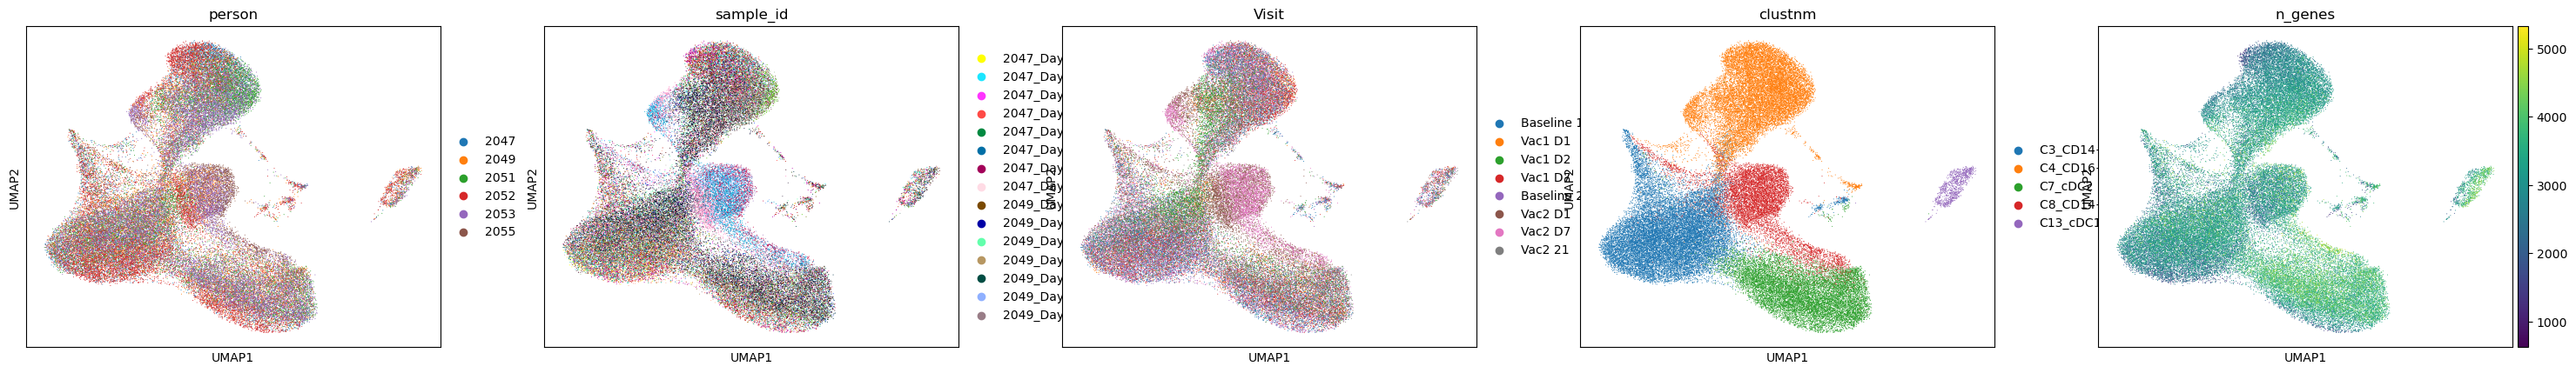

In [30]:
sc.pl.umap(combined, color = ['person', 'sample_id', 'Visit', 'clustnm', 'n_genes'], ncols=5)

In [31]:
combined

AnnData object with n_obs × n_vars = 58164 × 17703
    obs: 'pt_id', 'day', 'clustnm', 'sample_id', 'n_genes', 'person', 'Visit', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'is_outlier'
    var: 'n_cells', 'is_rna', 'is_protein', 'highly_variable', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'person_colors', 'sample_id_colors', 'Visit_colors', 'clustnm_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [32]:
sc.tl.leiden(combined, resolution=0.7, key_added='l070')

In [49]:
sc.tl.leiden(combined, resolution=0.4, key_added='l070_1', restrict_to=('l070', ['5']))

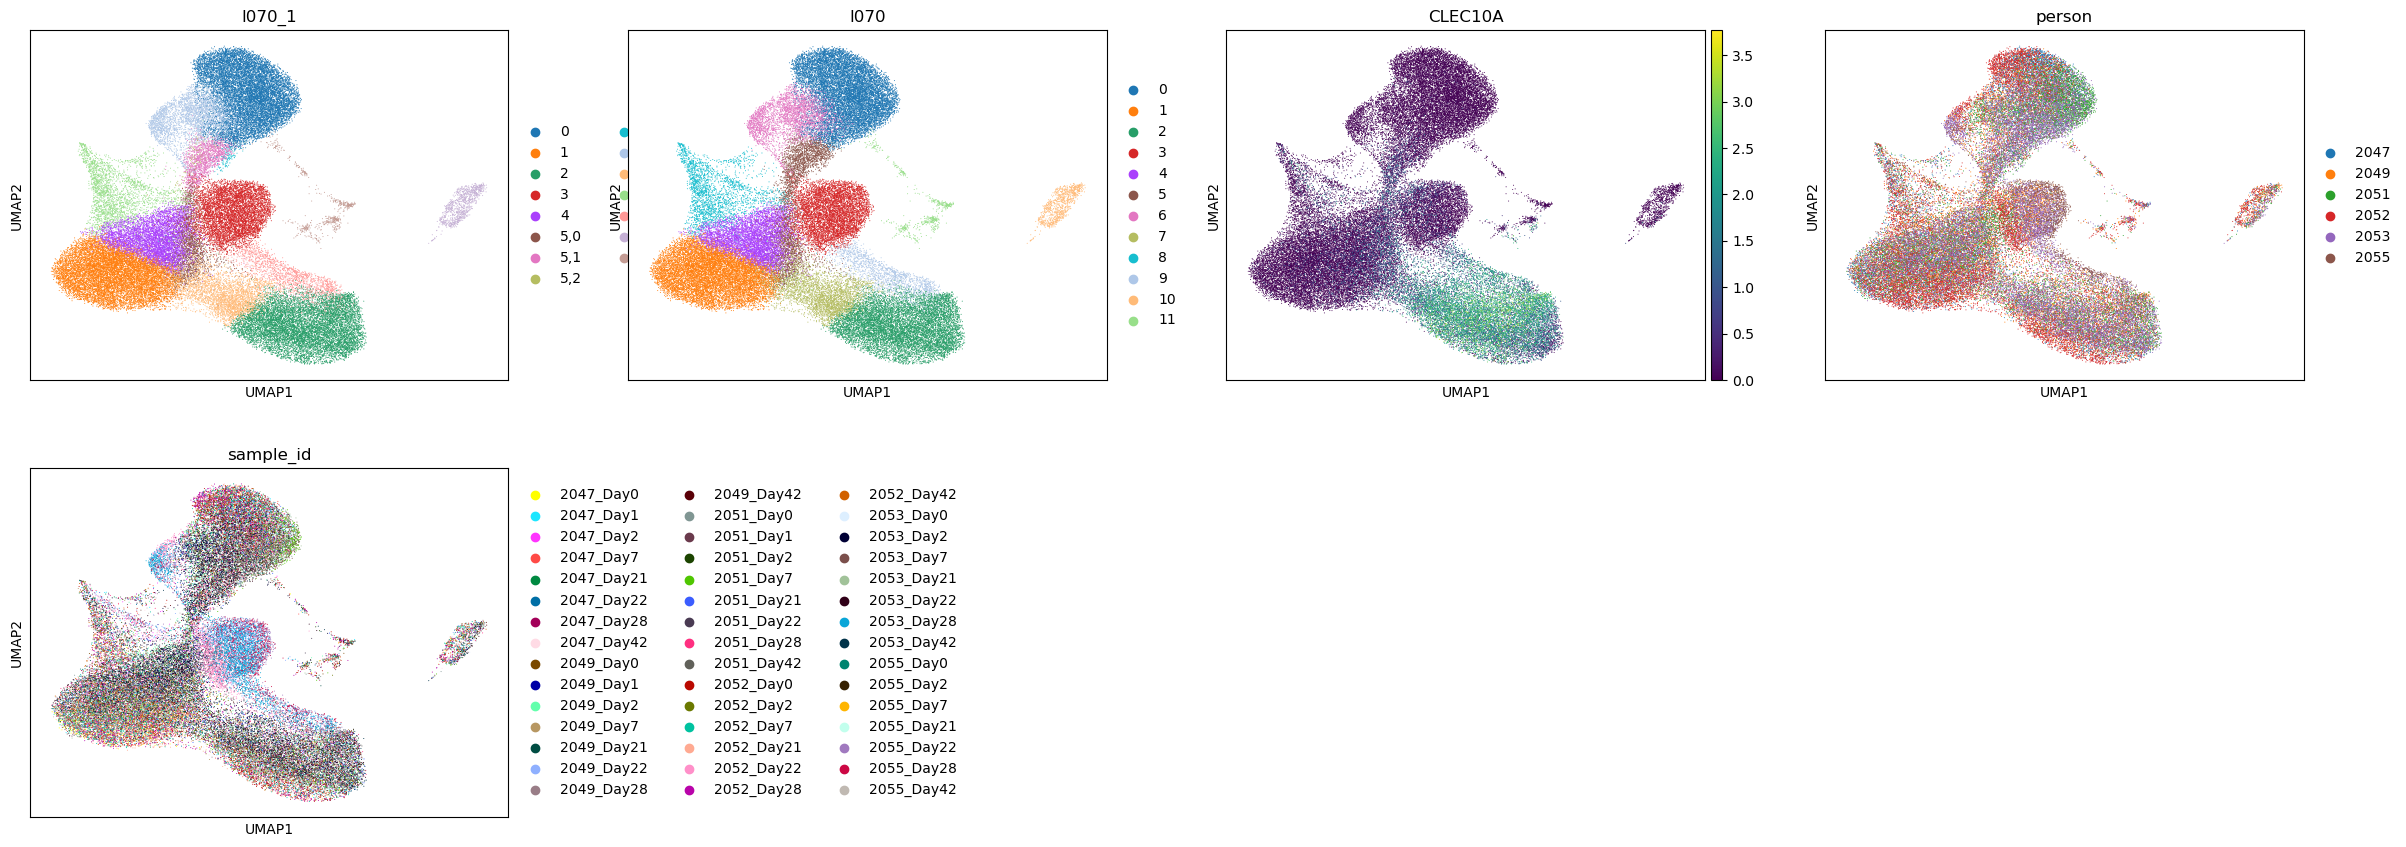

In [50]:
sc.pl.umap(combined, color = ['l070_1', 'l070', 'CLEC10A', 'person', 'sample_id'], layer='normalized')

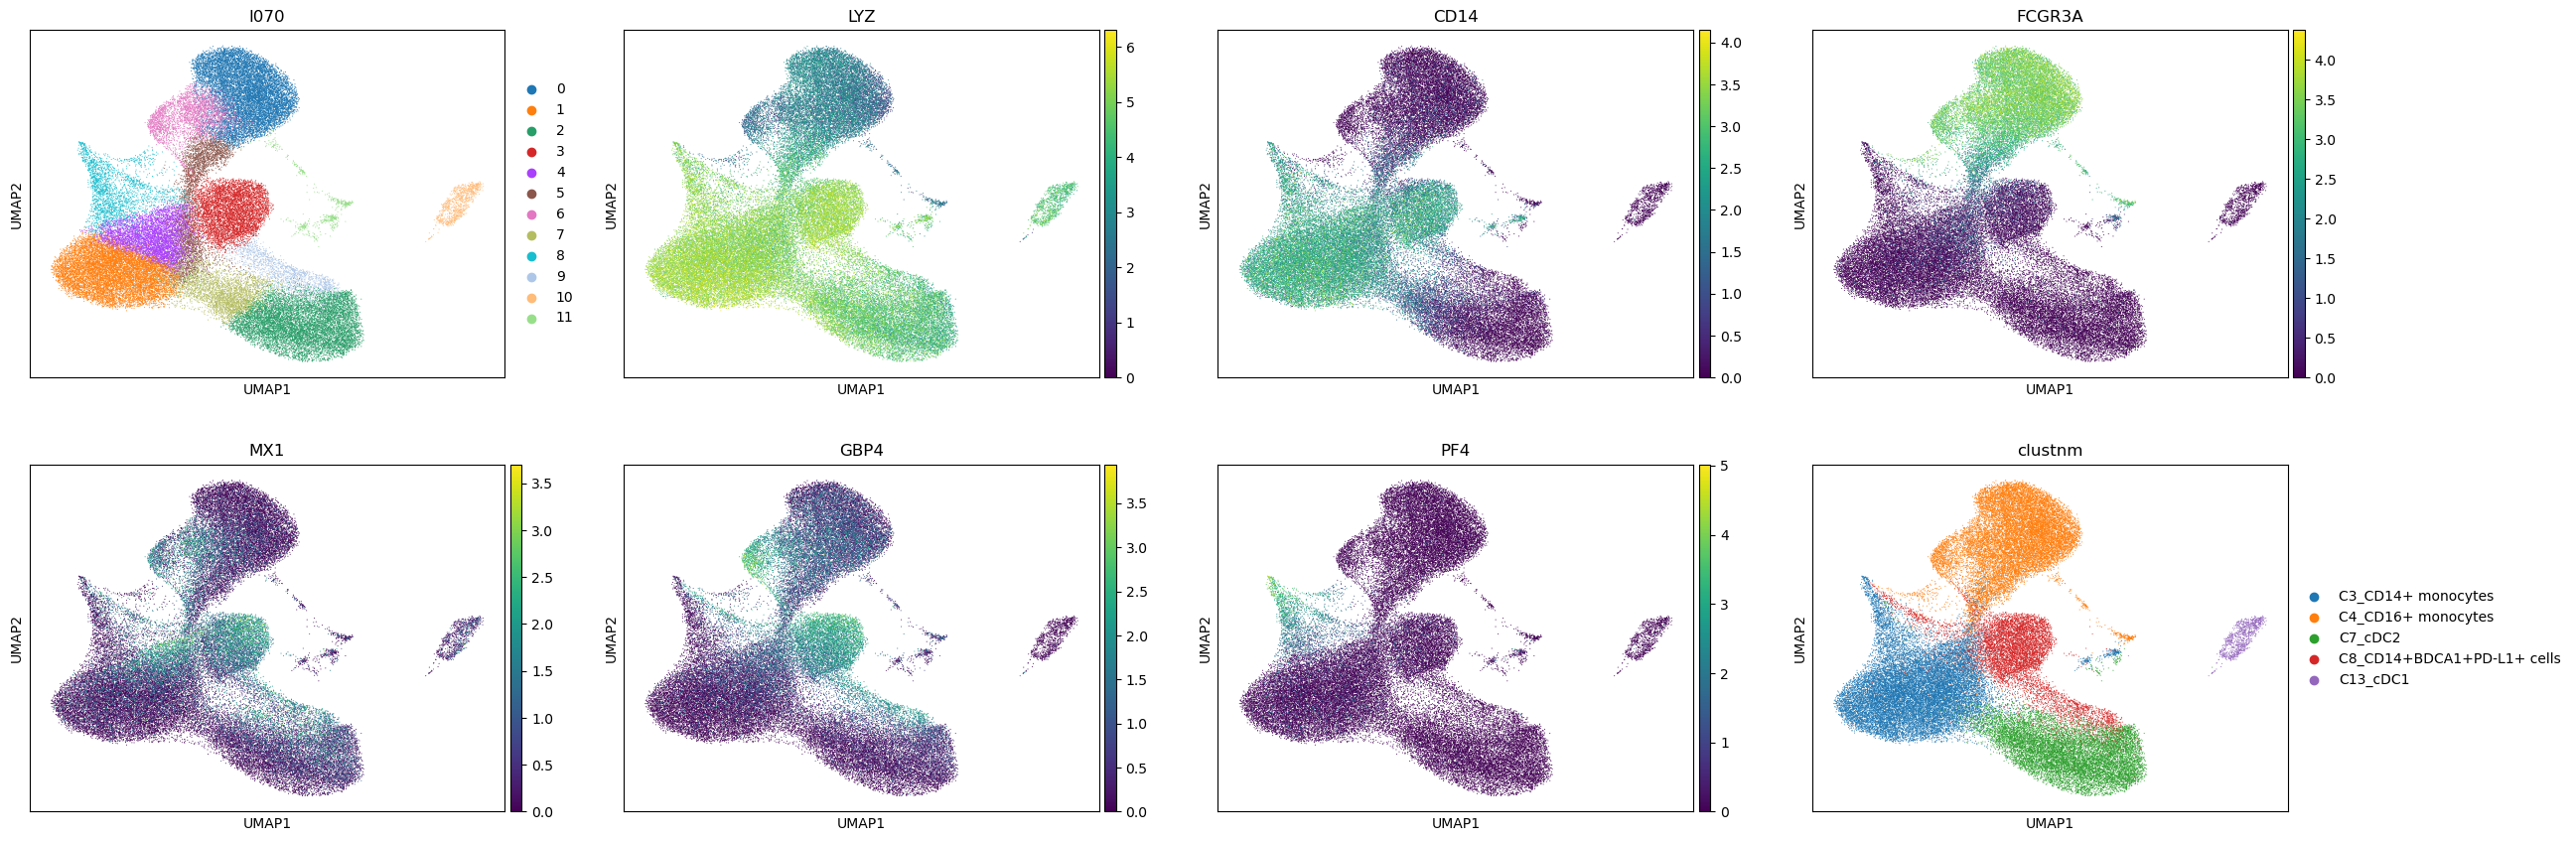

In [34]:
sc.pl.umap(combined, color = ['l070', 'LYZ', 'CD14', 'FCGR3A', 'MX1', 'GBP4', 'PF4', 'clustnm'], layer='normalized')

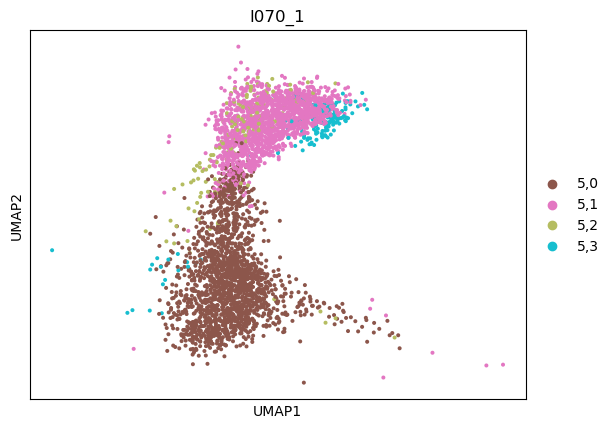

In [53]:
sc.pl.umap(combined[combined.obs.l070=='5'], color = ['l070_1'])


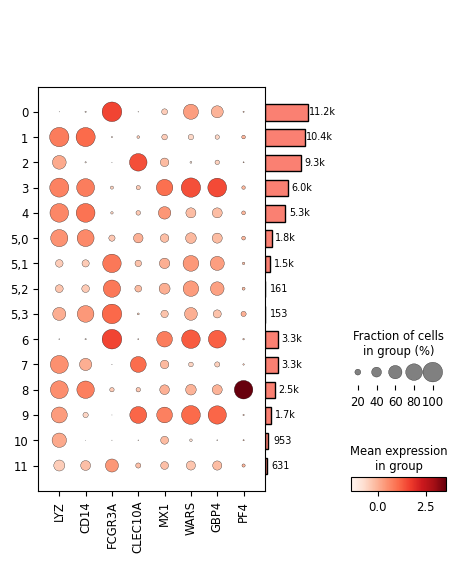

In [58]:
dp = sc.pl.dotplot(combined, ['LYZ', 'CD14', 'FCGR3A', 'CLEC10A', 'MX1', 'WARS', 'GBP4', 'PF4'], groupby='l070_1', return_fig=True)
dp.add_totals()
dp.make_figure()
# sc.pl.dotplot(combined, ['LYZ', 'CD14', 'FCGR3A', 'MX1', 'WARS', 'GBP4', 'PF4'], groupby='l090')

In [62]:
combined.obs['subsets_1'] = combined.obs['l070_1'].map({
    '0': 'Monocyte CD16',
    '1': 'Monocyte CD14',
    '2': 'cDC2',
    '3': 'Monocyte CD14',
    '4': 'Monocyte CD14',
    '5,0': 'Monocyte CD14',
    '5,1': 'Monocyte CD16',
    '5,2': 'Trash',
    '5,3': 'Trash',
    '6': 'Monocyte CD16',
    '7': 'cDC2',
    '8': 'MGK',
    '9': 'cDC2',
    '10': 'cDC1',
    '11': 'Trash'
})

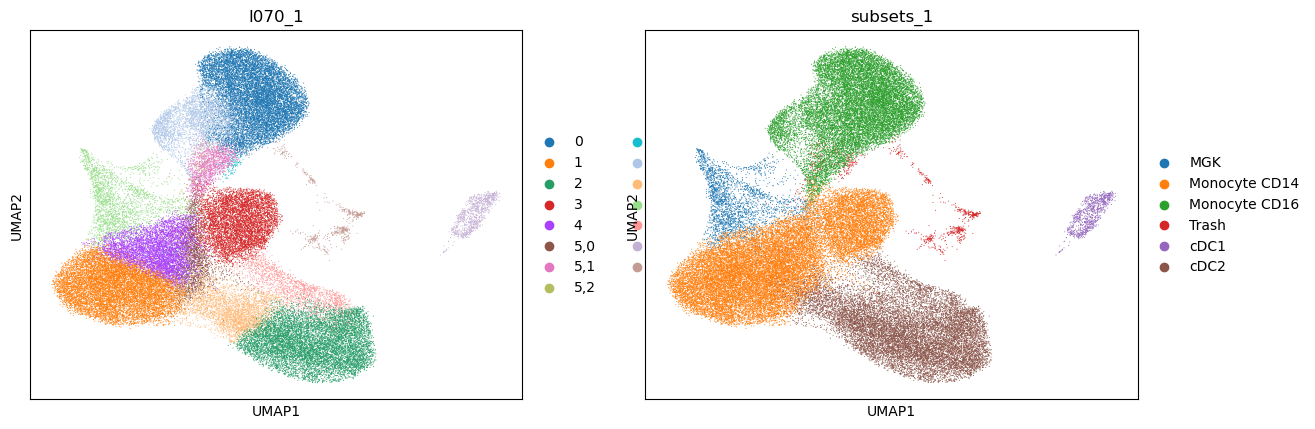

In [63]:
sc.pl.umap(combined, color = ['l070_1', 'subsets_1'], layer='normalized')

In [64]:
combined.write_h5ad('myeloid_1.h5ad')